In [ ]:
"""
- Dividing the dataset -------------------------------------------------------------------------------------------------------------------
CIFAR100 data was downloaded in https://www.cs.utoronto.ca/~kriz/cifar.html in which I use an already existing function called unpickle(file) to 
extract the nesccary batchfiles containng data, and label in which I'll specific fine” label to grab the 100 different files.

Using this data extract I'll specify the train and test data. Then I'll access only key of b'fine_labels', and b'data' as it will be the data need for
this assignment

The image data of train_x and text_x will converted to pyTorch tensors and reshaped a standard that is require for PyTorch convolutional networks.
'255.0' value normalization for pixel values of rgb. Additonal normalization is applied to scale the pixel value  scaling the range to [-1, 1]

The TensorDataset is created for both training and test data combine image and label tensor together. The random into a training and a validation set.
 80% of the data is kept for training (subtrain_dataset) and the remaining 20% for validation (validation_dataset). Hence the dividing set process.

 - Selecting the model '2c.#'s' -------------------------------------------------------------------------------------------------------------------
 Model experimentation was conducted to determine the desire model within these comment I'll provided top-view explanation of the specific hyperparameters 
 were tested. The range of experimentation was limited in scope but deemed necessary to avoid confusion regarding the new state of the model. Although the
 range was small, it provided the necessary direction to decide on the next set of model experimentation. 
 Determination of these factor were determine by these factors:
      - Values of the training accuracy/loss and validation accuracy/loss and observed the graph
      - Examine the stability, convergence, and level of overfitting/underfitting of the model with the new changes

2c.2
    - Hypertuning experimentation increasing the out_channels
        - layer1 out_channels=16
        - layer2 out_channels=32
        - fc1 out_features=120
    Result training process decrease 2.75->2.0

2c.2.1
     - Hypertuning experimentation increasing the out_channels
        - layer1 out_channels=32
        - layer2 out_channels=64
        - fc1 out_features=240
    Result  training process decrease 2.0->0.35
            growing concern gain by validation loss greatly exapand

2c.3 
    - Adding and adjusting dropout layers
        - Dropout added to layer 1, 2, and fc1 value set 0.2
    Result Gap of validation loss and training loss is getting closer togehter

2C.4
    - Introduce batch
        - batchnormalization was added layer1, layer2, layer3
    result faster convergence

2C.5
    - Increase the dropout by all layers from 2c.2 by incrememnt .1
    Result Training and validation loss gap is closer

2C.5.2
    -  Increase the dropout by all layers from 2c.2 by incrememnt .1
    Result Training and validation loss gap is closer and overfitting avoided

2c.6
    - lr change 1e-2
    Result unstable graph
    - lr change 1e-3
    Result graph unstable but not as much
    - lr change 1e-5
    Result slow growth of training rate
    Sticking with 1e-4

2c.7 
    - Adjusting adam betas
        - betas=(0.92, 0.995)
        result convergence is improve
        -  betas=(0.8, 0.95))
        result convergence is improve but not much
        -  betas=(0.78, 0.90)
        result convergence is improve earlist sticking with this

2c.8 *** Model select show the best result of training/valdiation loss and with test accracy of 46.43%
    - Adjust activation layer
        - layer1 leakyReLu
        - fc1 leakyReLu
    result stable curve and generalization
*****************************************************************************
        - layer1 ELU
        -layer2 ELU
    result convergence occurs much late in epoch
        - layer1 sigmoid
        - layer2 sigmoid
    result convergence not occurs and validation stop improving

2c.9 
    - Adjust batch size
        - batch 128
    Result test Accuracy has decrease and graph is unstable longer compute
        - batch  32
    Result no convergence and validation stop improving batch 30
"""

In [206]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn, optim
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
50000
[[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 ...
 [248 240 236 ... 180 174 205]
 [156 151 151 ... 114 107 126]
 [ 31  30  31 ...  72  69  67]]
(50000, 3072)
(3, 32, 32)
(32, 32, 3)


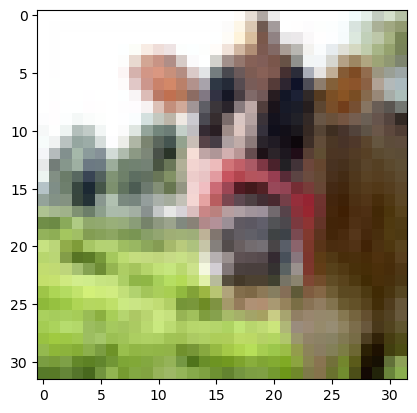

In [208]:
#find path to the folder
file_path = "C:/Users/Johnn/OneDrive/Documents/CNN/Models"
data_dir = 'C:/Users/Johnn/OneDrive/Documents/CNN/Models/cifar-100-python'


# Function to load a file from the dataset
def unpickle(file_path):
    with open(file_path, 'rb') as file:
        dict  = pickle.load(file, encoding='bytes')
    return dict

# Load the training and test data
train_data = unpickle(f'{data_dir}/train')
test_data = unpickle(f'{data_dir}/test')

# visualization of one picture and label

print(train_data.keys())
# fine labels identify the class of the image
print(len(train_data[b'fine_labels']))
# Will access the data values
print(train_data[b'data'])
print(train_data[b'data'].shape)

# visualize the cifar-100 image by reshaping
image = train_data[b'data'][0]
# divide 3 channels represents into rgb by 32x32 matrixs 
image = image.reshape(3, 32, 32)
print(image.shape)
# transpose it to 32 x 32 x 3 
image = image.transpose(1, 2, 0)
print(image.shape)
plt.imshow(image)

In [48]:
# Split the training data into a training and a validation set
# Accessing the fine_labels from dic will ensure that the model will predict 100 Classes rather than the super-classes
# train_x raw pixel data for the images, train_y class identifiers you that it needs to predict
train_x, train_y = train_data[b'data'], train_data[b'fine_labels']
test_x, test_y = test_data[b'data'], test_data[b'fine_labels']

# ensure that the images and specific classes match same length
print(f'Train data: {len(train_x)} , Validation data: {len(train_y)}')
print(f'{type(train_x)}, {type(train_y)}')
# convert to tensors
train_x = torch.tensor(train_x, dtype=torch.float32).view(-1, 3, 32, 32) / 255.0
train_y = torch.tensor(train_y, dtype=torch.long)
test_x = torch.tensor(test_x, dtype=torch.float32).view(-1, 3, 32, 32) / 255.0
test_y = torch.tensor(test_y, dtype=torch.long)
print(train_x.shape)

# Normalize the tensors using the 0.5 mean and 0.5 std
mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std


# wraps imange label tensor together
dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)


# to ensure that 1/5 alloaction will be given to validation check length of subtrain
train_size = int(0.8 * len(dataset))
# Next is to split the dataset into training 4/5 and validation sets 1/5 'random_split' function will ensure it is randonly allocated
subtrain_dataset, validation_dataset = random_split(dataset, [train_size, (len(dataset) - train_size)])
print(f'train: {len(subtrain_dataset)}, val:{len(validation_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train data: 50000 , Validation data: 50000
<class 'numpy.ndarray'>, <class 'list'>
torch.Size([50000, 3, 32, 32])
train: 40000, val:10000


In [49]:
batch_size = 64
num_epochs = 100

In [200]:
def train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs):
    # Create data loaders for the training and validation sets
    subtrain_loader = DataLoader(subtrain_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    tr_acc, tr_loss = [], []
    
    val_acc, val_loss = [], []
    best_val_loss = float('inf')
    early_stop = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in subtrain_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Calculate predictions for train accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_accuracy = correct_train / total_train
        tr_acc.append(train_accuracy)
        train_loss = running_loss / len(subtrain_loader)
        tr_loss.append(train_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
        # Validation loop
        model.eval()
        validation_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        validation_loss /= len(validation_loader)
        val_loss.append(validation_loss)
        validation_accuracy =  correct / total
        val_acc.append(validation_accuracy)

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save(model.state_dict(), 'LeNetmodel_best_parameters.pth')
            early_stop = 0
        else:
            early_stop += 1
            if early_stop >= 10:
                print(f'Early stopping on epoch {epoch}/{num_epochs}')
                torch.save(model.state_dict(), 'LeNetmodel_latest_parameters.pth')
                break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')  
    print('Training Completed')
    return tr_acc, tr_loss, val_acc, val_loss



def test_model(model,test_loader):
    #model = model.to(device)
    model.eval()

    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * (correct / total)
    print(f'Test Accuracy: {test_accuracy:.4f}%')
    

def plot_model(tr_acc, tr_loss, val_acc, val_loss):
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Baseline Model uses LeNet 1998

In [51]:
# Base design
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + ReLU + Average Pooling
        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            # ((32 - 5 + 2(1))/ 1) + 1 = 30x30   channels 6
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            # 28/2 = 14 
        )
        # Output size:  14x14x6

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            # ((14 − 5 + 2(0))/1)+1=   10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            # 10/2 = 5
        )
        # Output size: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=84, out_features=100)  # CIFAR-100 has 100 classes
         
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


### 2c.1 Model Experimentation Let began with simple design of LeNet 1982

In [53]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [55]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.6121, Training Accuracy: 0.1591
Epoch 9/100, Validation Loss: 3.6138, Validation Accuracy: 0.1596
Epoch 19/100, Training Loss: 3.3504, Training Accuracy: 0.2009
Epoch 19/100, Validation Loss: 3.4041, Validation Accuracy: 0.1933
Epoch 29/100, Training Loss: 3.1744, Training Accuracy: 0.2347
Epoch 29/100, Validation Loss: 3.2827, Validation Accuracy: 0.2149
Epoch 39/100, Training Loss: 3.0424, Training Accuracy: 0.2602
Epoch 39/100, Validation Loss: 3.2102, Validation Accuracy: 0.2264
Epoch 49/100, Training Loss: 2.9393, Training Accuracy: 0.2793
Epoch 49/100, Validation Loss: 3.1525, Validation Accuracy: 0.2419
Epoch 59/100, Training Loss: 2.8543, Training Accuracy: 0.2948
Epoch 59/100, Validation Loss: 3.1309, Validation Accuracy: 0.2468
Epoch 69/100, Training Loss: 2.7832, Training Accuracy: 0.3081
Epoch 69/100, Validation Loss: 3.1006, Validation Accuracy: 0.2548
Epoch 79/100, Training Loss: 2.7196, Training Accuracy: 0.3206
Epoch 79/100, Validation Loss

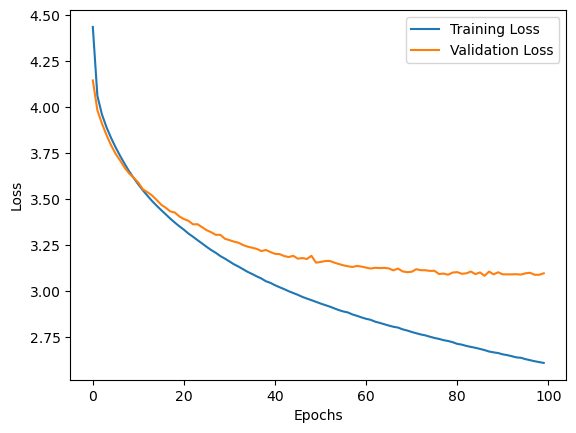

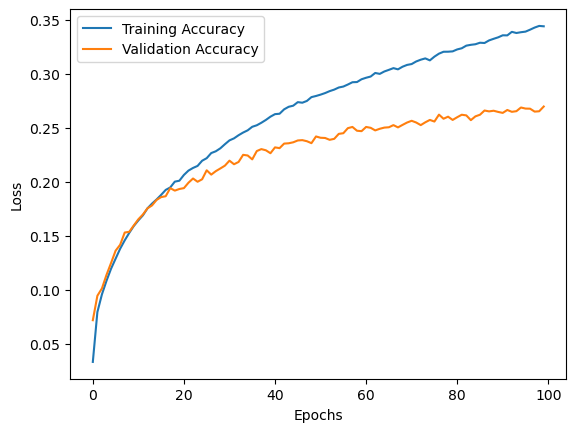

In [56]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [57]:
test_model(model, test_loader)

Test Accuracy: 25.9900%


In [ ]:
# Want to improve the training process so, I'll increase the channels to introduce the need of more features
# Since CIFAR 100 has 100 classifciation compare to regular use case of a MINST 10 classifciation
# The increase features of CONV2D layers mayprove to be beneficial 

## 2c.2 Hyperpramater: Experimentation Increasing the depth channels
out_channels: where change to pervious model to test result

In [63]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [62]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
       
        # Layer 1: Conv2d + ReLU + Average Pooling
        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2), # Increase from 6 to 16 channels
            # (32 - 5 + 2(2)/1) + 1 = 32
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            # 32/2 = 16
        )
        # Output size: 16x16x16

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # Increase from 16 to 32 channels
            # (16 - 5 + 2(0)/1) + 1 = 12
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            12/2 = 6
        )
        # Output size: 6x6x32

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=32 * 6 * 6, out_features=120), # Increase from 16 to 32 inchannels
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=84, out_features=100) 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [64]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.3649, Training Accuracy: 0.2042
Epoch 9/100, Validation Loss: 3.3899, Validation Accuracy: 0.2049
Epoch 19/100, Training Loss: 3.0002, Training Accuracy: 0.2728
Epoch 19/100, Validation Loss: 3.1636, Validation Accuracy: 0.2426
Epoch 29/100, Training Loss: 2.7533, Training Accuracy: 0.3212
Epoch 29/100, Validation Loss: 3.0849, Validation Accuracy: 0.2600
Epoch 39/100, Training Loss: 2.5703, Training Accuracy: 0.3572
Epoch 39/100, Validation Loss: 3.0338, Validation Accuracy: 0.2729
Epoch 49/100, Training Loss: 2.4199, Training Accuracy: 0.3866
Epoch 49/100, Validation Loss: 3.0285, Validation Accuracy: 0.2819
Epoch 59/100, Training Loss: 2.2819, Training Accuracy: 0.4177
Epoch 59/100, Validation Loss: 3.0237, Validation Accuracy: 0.2862
Epoch 69/100, Training Loss: 2.1561, Training Accuracy: 0.4448
Epoch 69/100, Validation Loss: 3.0792, Validation Accuracy: 0.2916
Epoch 79/100, Training Loss: 2.0331, Training Accuracy: 0.4706
Epoch 79/100, Validation Loss

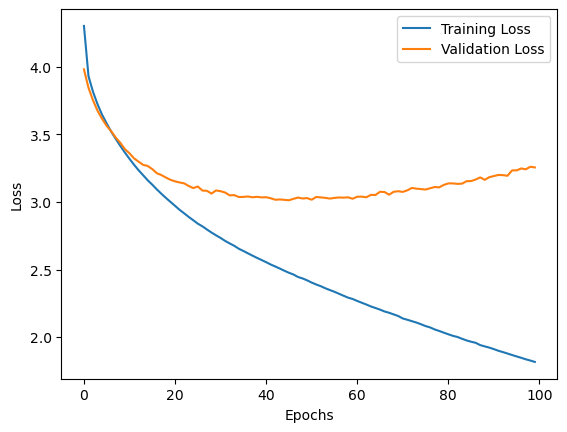

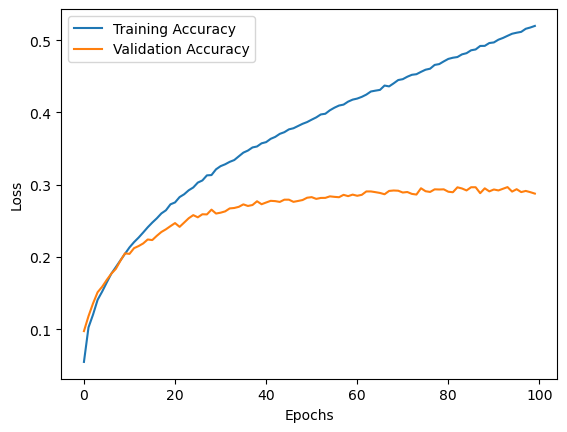

In [65]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [66]:
test_model(model, test_loader)

Test Accuracy: 29.0300%


In [ ]:
# Overfitting is increase but the training process has decrease 2.75->2.0 
# Want to test if this trend will continue so I may increase channels once more to see

## 2c.2.1 Hypertuning experimentation increasing the out_channels

In [67]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + ReLU + Average Pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), # Increase from 16 to 32 channels
            # (32 - 5 + 2(2)/1) + 1 = 32
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            # 32/2 = 16
        )
        # Output size: 16x16x16

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # Increase from 32 to 64 channels
            #  (16 - 5 + 2(0)/1) + 1 = 12
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            # 12/2 = 6
        )
        # Output size: 6x6x32

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240), # increase 120 to 240 channels 
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)  
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [68]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [69]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.0349, Training Accuracy: 0.2628
Epoch 9/100, Validation Loss: 3.1256, Validation Accuracy: 0.2484
Epoch 19/100, Training Loss: 2.5839, Training Accuracy: 0.3523
Epoch 19/100, Validation Loss: 2.9473, Validation Accuracy: 0.2886
Epoch 29/100, Training Loss: 2.2417, Training Accuracy: 0.4247
Epoch 29/100, Validation Loss: 2.9230, Validation Accuracy: 0.3008
Epoch 39/100, Training Loss: 1.9293, Training Accuracy: 0.4937
Epoch 39/100, Validation Loss: 2.9900, Validation Accuracy: 0.3084
Epoch 49/100, Training Loss: 1.6266, Training Accuracy: 0.5656
Epoch 49/100, Validation Loss: 3.1833, Validation Accuracy: 0.3064
Epoch 59/100, Training Loss: 1.3329, Training Accuracy: 0.6376
Epoch 59/100, Validation Loss: 3.4961, Validation Accuracy: 0.2975
Epoch 69/100, Training Loss: 1.0478, Training Accuracy: 0.7116
Epoch 69/100, Validation Loss: 3.9212, Validation Accuracy: 0.2898
Epoch 79/100, Training Loss: 0.7860, Training Accuracy: 0.7834
Epoch 79/100, Validation Loss

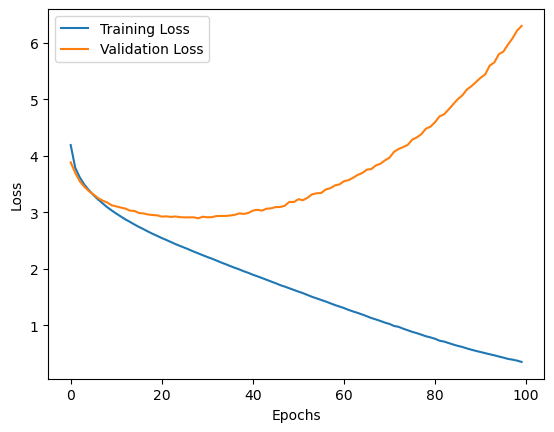

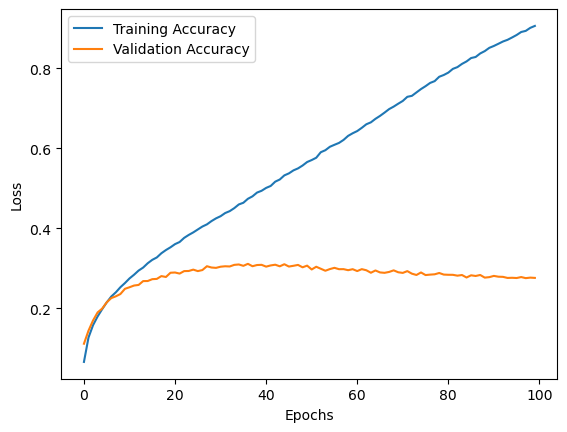

In [70]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [71]:
test_model(model, test_loader)

Test Accuracy: 27.8900%


In [ ]:
# Training process has increase dramatically so it prove to be a sucess in someway
# May need to began optimizing the need of dropout layers as the changes made so far has
# greatly expand the growing concern of overfitting as shown from the validation loss
# increasing thus, experimentation on the dropout layers may prove to be a benfit to this issue

## 2C.3 Introducting Dropout layers

In [207]:
# Hyperparameter ranges


In [73]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + ReLU + Average Pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        # Output size: 16x16x16

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        # Output size: 6x6x32 

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100) 
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [74]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [75]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.1685, Training Accuracy: 0.2301
Epoch 9/100, Validation Loss: 3.1350, Validation Accuracy: 0.2401
Epoch 19/100, Training Loss: 2.8113, Training Accuracy: 0.2970
Epoch 19/100, Validation Loss: 2.9008, Validation Accuracy: 0.2856
Epoch 29/100, Training Loss: 2.5504, Training Accuracy: 0.3517
Epoch 29/100, Validation Loss: 2.7747, Validation Accuracy: 0.3145
Epoch 39/100, Training Loss: 2.3258, Training Accuracy: 0.3941
Epoch 39/100, Validation Loss: 2.7241, Validation Accuracy: 0.3304
Epoch 49/100, Training Loss: 2.1343, Training Accuracy: 0.4298
Epoch 49/100, Validation Loss: 2.7105, Validation Accuracy: 0.3339
Epoch 59/100, Training Loss: 1.9680, Training Accuracy: 0.4704
Epoch 59/100, Validation Loss: 2.7325, Validation Accuracy: 0.3427
Epoch 69/100, Training Loss: 1.8049, Training Accuracy: 0.5029
Epoch 69/100, Validation Loss: 2.7734, Validation Accuracy: 0.3430
Epoch 79/100, Training Loss: 1.6721, Training Accuracy: 0.5315
Epoch 79/100, Validation Loss

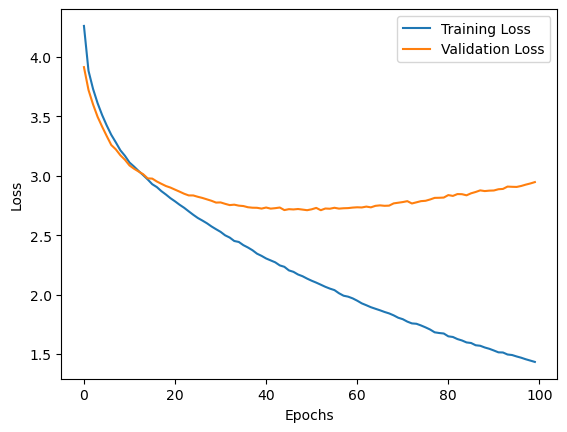

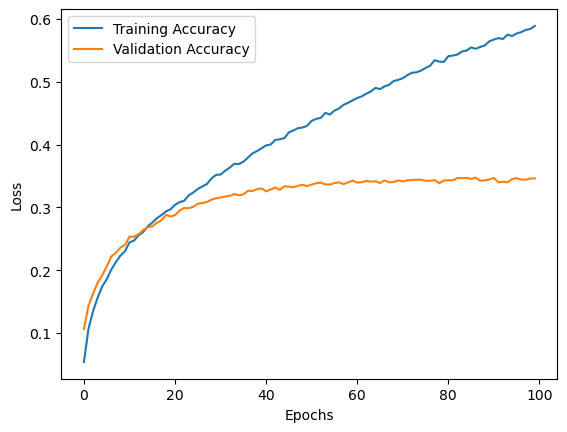

In [76]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [77]:
test_model(model, test_loader)

Test Accuracy: 34.4300%


In [ ]:
# Dropout layers that was introduce has prove to be greatly reduce the overfitting
# the once alarm rate of the validation loss has been somewhat address
# nonetheless, the validation still increase after certain point.
# may address this by introducting dropoutlayer, I want to experiment the batch normalization as the convergence at epoch 20
# may be increase to faster time. 

### 2C.4 Introduction of Batch Normalization 

In [84]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Layer 1: Conv2d + ReLU + Average Pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32), # Added
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2) 
        )
        # Output size: 16x16x16

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), 
            nn.ReLU(),
            nn.BatchNorm2d(64), # Added
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2) 
        )
        # Output size: 6x6x32

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240), 
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.BatchNorm1d(240) # Added
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)  
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [85]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [86]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.2630, Training Accuracy: 0.4092
Epoch 9/100, Validation Loss: 2.4006, Validation Accuracy: 0.3829
Epoch 19/100, Training Loss: 1.7241, Training Accuracy: 0.5258
Epoch 19/100, Validation Loss: 2.2648, Validation Accuracy: 0.4228
Epoch 29/100, Training Loss: 1.4058, Training Accuracy: 0.6009
Epoch 29/100, Validation Loss: 2.2781, Validation Accuracy: 0.4320
Epoch 39/100, Training Loss: 1.1941, Training Accuracy: 0.6529
Epoch 39/100, Validation Loss: 2.3473, Validation Accuracy: 0.4371
Epoch 49/100, Training Loss: 1.0336, Training Accuracy: 0.6908
Epoch 49/100, Validation Loss: 2.4125, Validation Accuracy: 0.4410
Epoch 59/100, Training Loss: 0.9348, Training Accuracy: 0.7148
Epoch 59/100, Validation Loss: 2.4918, Validation Accuracy: 0.4387
Epoch 69/100, Training Loss: 0.8619, Training Accuracy: 0.7347
Epoch 69/100, Validation Loss: 2.5556, Validation Accuracy: 0.4401
Epoch 79/100, Training Loss: 0.7807, Training Accuracy: 0.7603
Epoch 79/100, Validation Loss

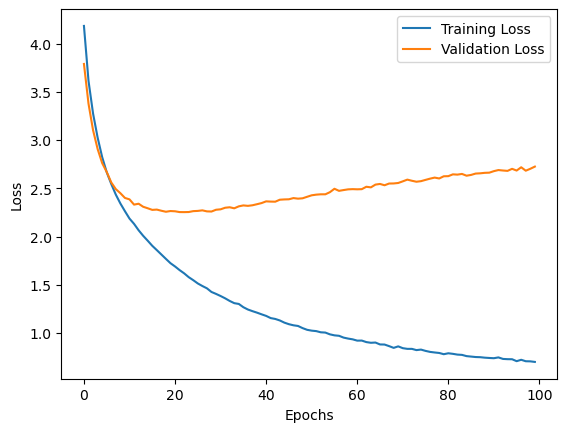

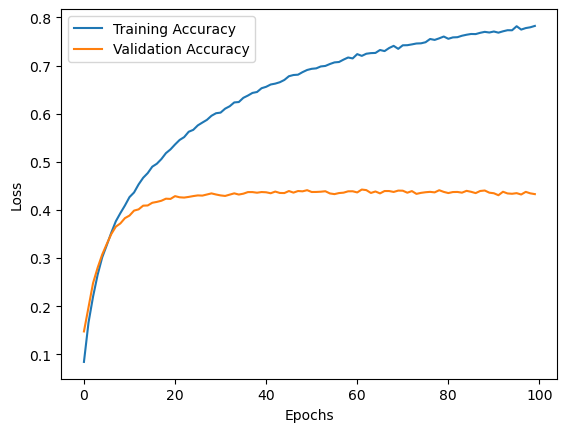

In [87]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [88]:
test_model(model, test_loader)

Test Accuracy: 42.9400%


In [93]:
# Overfitting seem to be extremetly present issue , however training accuracy has greatly improve
# The training loss has greatly smooth the curve
# May need to increase the dropout

## 2c.5 Dropout increase

In [89]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + ReLU + Average Pooling
        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3) # .2 -> .3
        )
        # Output size: 16x16x16

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3) # .2 -> .3
        )
        # Output size: 6x6x64

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240), 
            nn.ReLU(),
            nn.Dropout(0.4), # .3 -> .4
            nn.BatchNorm1d(240)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [90]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [91]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.6551, Training Accuracy: 0.3229
Epoch 9/100, Validation Loss: 2.5824, Validation Accuracy: 0.3410
Epoch 19/100, Training Loss: 2.2659, Training Accuracy: 0.4028
Epoch 19/100, Validation Loss: 2.3106, Validation Accuracy: 0.4031
Epoch 29/100, Training Loss: 2.0352, Training Accuracy: 0.4511
Epoch 29/100, Validation Loss: 2.1937, Validation Accuracy: 0.4290
Epoch 39/100, Training Loss: 1.8845, Training Accuracy: 0.4832
Epoch 39/100, Validation Loss: 2.1404, Validation Accuracy: 0.4399
Epoch 49/100, Training Loss: 1.7848, Training Accuracy: 0.5029
Epoch 49/100, Validation Loss: 2.1061, Validation Accuracy: 0.4515
Epoch 59/100, Training Loss: 1.6861, Training Accuracy: 0.5295
Epoch 59/100, Validation Loss: 2.0898, Validation Accuracy: 0.4599
Epoch 69/100, Training Loss: 1.6280, Training Accuracy: 0.5412
Epoch 69/100, Validation Loss: 2.0945, Validation Accuracy: 0.4584
Epoch 79/100, Training Loss: 1.5675, Training Accuracy: 0.5571
Epoch 79/100, Validation Loss

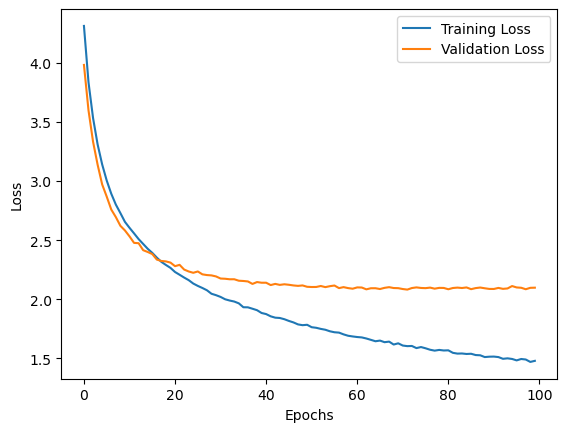

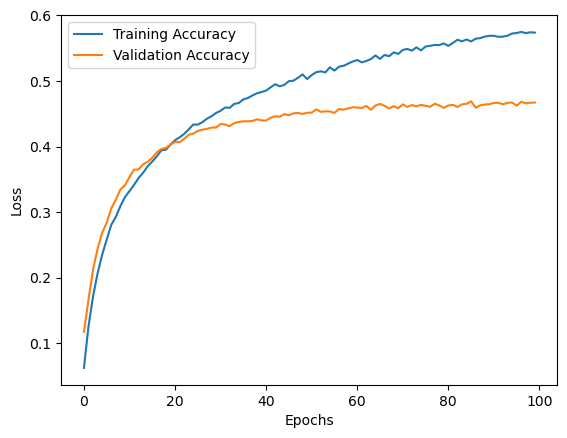

In [92]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [94]:
test_model(model, test_loader)

Test Accuracy: 46.2200%


In [ ]:
# The increase dropout has improve the levels of increase overfit
# it made inpact on train/val accuracy, nonetheless still want to adjust the dropout rates to see
# better improvement made to the overfitting 

## 2c.5.2 Batch increase once more

In [116]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + ReLU + Average Pooling
        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4) # .3 -> .4 
        )
        # Output size: 16x16x16

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4) # .3 -> .4 
        )
        # Output size: 6x6x64

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240),  
            nn.ReLU(),
            nn.Dropout(0.5), # .4 -> .5
            nn.BatchNorm1d(240)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100) 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [117]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4)

In [118]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.9042, Training Accuracy: 0.2699
Epoch 9/100, Validation Loss: 2.7321, Validation Accuracy: 0.3093
Epoch 19/100, Training Loss: 2.5600, Training Accuracy: 0.3388
Epoch 19/100, Validation Loss: 2.4144, Validation Accuracy: 0.3752
Epoch 29/100, Training Loss: 2.3823, Training Accuracy: 0.3751
Epoch 29/100, Validation Loss: 2.2843, Validation Accuracy: 0.4016
Epoch 39/100, Training Loss: 2.2759, Training Accuracy: 0.3970
Epoch 39/100, Validation Loss: 2.2016, Validation Accuracy: 0.4232
Epoch 49/100, Training Loss: 2.1728, Training Accuracy: 0.4184
Epoch 49/100, Validation Loss: 2.1432, Validation Accuracy: 0.4376
Epoch 59/100, Training Loss: 2.1018, Training Accuracy: 0.4336
Epoch 59/100, Validation Loss: 2.1016, Validation Accuracy: 0.4471
Epoch 69/100, Training Loss: 2.0466, Training Accuracy: 0.4446
Epoch 69/100, Validation Loss: 2.0705, Validation Accuracy: 0.4486
Epoch 79/100, Training Loss: 2.0117, Training Accuracy: 0.4518
Epoch 79/100, Validation Loss

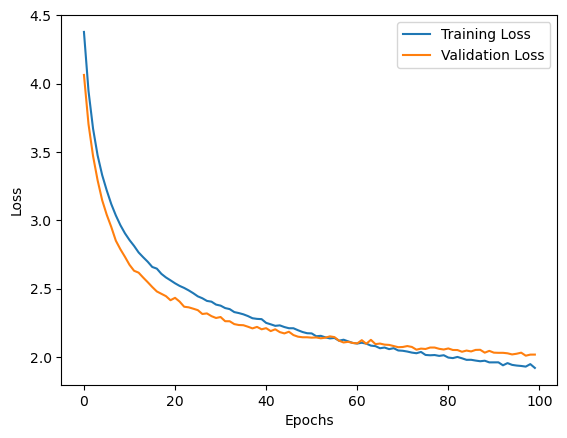

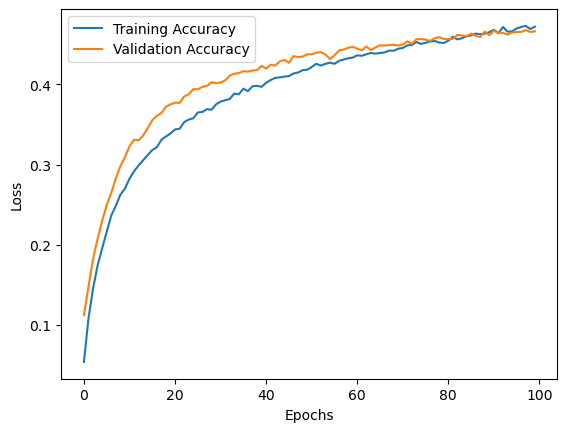

In [119]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [120]:
test_model(model, test_loader)

Test Accuracy: 46.4000%


In [121]:
torch.save({
    '1c-model_state_dict': model.state_dict(),
    '1c-optimizer_state_dict': optimizer.state_dict(),
}, '1c-model_checkpoint.pth')

In [ ]:
# Overfitting has been resolve 
# the increase droprout has lower the training process 1.5 -> 2.0
# may want to tinker around with lr to see any improvement can be made 

### 2c.6 Adjusting learning rate hyperpramater

In [122]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-2) # .2->.4

In [123]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.0080, Training Accuracy: 0.2510
Epoch 9/100, Validation Loss: 2.8159, Validation Accuracy: 0.2844
Epoch 19/100, Training Loss: 2.7610, Training Accuracy: 0.2964
Epoch 19/100, Validation Loss: 2.5255, Validation Accuracy: 0.3492
Epoch 29/100, Training Loss: 2.6215, Training Accuracy: 0.3262
Epoch 29/100, Validation Loss: 2.4390, Validation Accuracy: 0.3716
Epoch 39/100, Training Loss: 2.5452, Training Accuracy: 0.3392
Epoch 39/100, Validation Loss: 2.4050, Validation Accuracy: 0.3747
Epoch 49/100, Training Loss: 2.4659, Training Accuracy: 0.3569
Epoch 49/100, Validation Loss: 2.3486, Validation Accuracy: 0.3864
Epoch 59/100, Training Loss: 2.4207, Training Accuracy: 0.3643
Epoch 59/100, Validation Loss: 2.3034, Validation Accuracy: 0.4027
Epoch 69/100, Training Loss: 2.3786, Training Accuracy: 0.3745
Epoch 69/100, Validation Loss: 2.3466, Validation Accuracy: 0.3942
Epoch 79/100, Training Loss: 2.3483, Training Accuracy: 0.3816
Epoch 79/100, Validation Loss

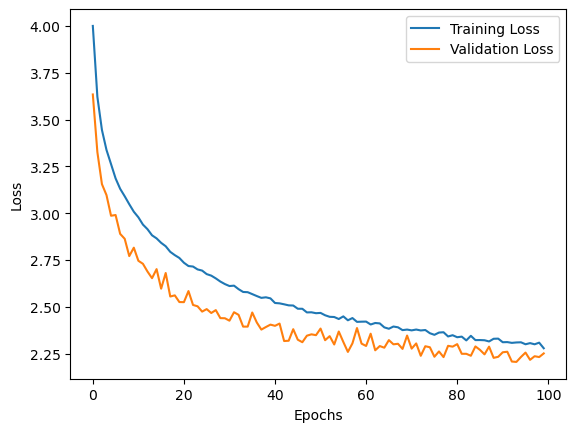

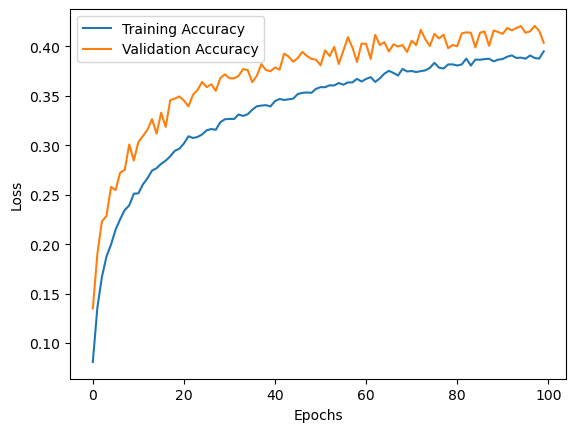

In [125]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# Seem unstable with the learning rate may need to lower it down
# to see a more stable version

In [128]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-3) #.4 -> 0.3

In [129]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.5261, Training Accuracy: 0.3419
Epoch 9/100, Validation Loss: 2.3370, Validation Accuracy: 0.3897
Epoch 19/100, Training Loss: 2.2872, Training Accuracy: 0.3945
Epoch 19/100, Validation Loss: 2.2218, Validation Accuracy: 0.4196
Epoch 29/100, Training Loss: 2.1561, Training Accuracy: 0.4199
Epoch 29/100, Validation Loss: 2.0979, Validation Accuracy: 0.4481
Epoch 39/100, Training Loss: 2.0685, Training Accuracy: 0.4393
Epoch 39/100, Validation Loss: 2.0367, Validation Accuracy: 0.4589
Epoch 49/100, Training Loss: 1.9949, Training Accuracy: 0.4545
Epoch 49/100, Validation Loss: 2.0155, Validation Accuracy: 0.4694
Epoch 59/100, Training Loss: 1.9888, Training Accuracy: 0.4554
Epoch 59/100, Validation Loss: 2.0271, Validation Accuracy: 0.4643
Epoch 69/100, Training Loss: 1.9131, Training Accuracy: 0.4739
Epoch 69/100, Validation Loss: 1.9787, Validation Accuracy: 0.4754
Epoch 79/100, Training Loss: 1.8666, Training Accuracy: 0.4845
Epoch 79/100, Validation Loss

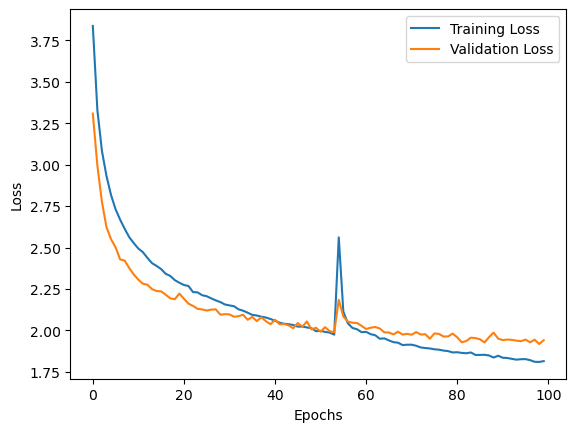

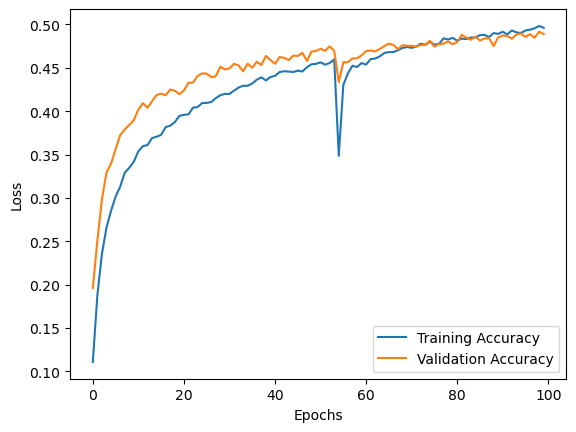

In [130]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# Seem imporve but it remians unstable with the learning rate may need to lower it down
# to see a more stable version

In [131]:
# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer= optim.Adam(model.parameters(),lr=1e-5) # .4 -> .5

In [132]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 4.1075, Training Accuracy: 0.0852
Epoch 9/100, Validation Loss: 4.0147, Validation Accuracy: 0.1056
Epoch 19/100, Training Loss: 3.7581, Training Accuracy: 0.1328
Epoch 19/100, Validation Loss: 3.6829, Validation Accuracy: 0.1482
Epoch 29/100, Training Loss: 3.5354, Training Accuracy: 0.1696
Epoch 29/100, Validation Loss: 3.4543, Validation Accuracy: 0.1863
Epoch 39/100, Training Loss: 3.3698, Training Accuracy: 0.1959
Epoch 39/100, Validation Loss: 3.2888, Validation Accuracy: 0.2134
Epoch 49/100, Training Loss: 3.2290, Training Accuracy: 0.2186
Epoch 49/100, Validation Loss: 3.1297, Validation Accuracy: 0.2403
Epoch 59/100, Training Loss: 3.1232, Training Accuracy: 0.2365
Epoch 59/100, Validation Loss: 3.0209, Validation Accuracy: 0.2584
Epoch 69/100, Training Loss: 3.0205, Training Accuracy: 0.2557
Epoch 69/100, Validation Loss: 2.9204, Validation Accuracy: 0.2740


KeyboardInterrupt: 

In [ ]:
# The lower version of the lr 1e-4 -> 1e-5 has prove to be siginifcant slower training process
# will abort this and focus on tweaking optimizer pramaters to see any improvement to be made

## 2c.7 Adjusting adam betas

In [ ]:
# sticking with the lr 1e-4 
# May start tuning the adam betas may find a good range of finding best convergence

In [135]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.92, 0.995))

In [136]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.9893, Training Accuracy: 0.2594
Epoch 9/100, Validation Loss: 2.8778, Validation Accuracy: 0.2854
Epoch 19/100, Training Loss: 2.6107, Training Accuracy: 0.3293
Epoch 19/100, Validation Loss: 2.4996, Validation Accuracy: 0.3605
Epoch 29/100, Training Loss: 2.4261, Training Accuracy: 0.3664
Epoch 29/100, Validation Loss: 2.3650, Validation Accuracy: 0.3907
Epoch 39/100, Training Loss: 2.2894, Training Accuracy: 0.3982
Epoch 39/100, Validation Loss: 2.2589, Validation Accuracy: 0.4103
Epoch 49/100, Training Loss: 2.1985, Training Accuracy: 0.4151
Epoch 49/100, Validation Loss: 2.1845, Validation Accuracy: 0.4233
Epoch 59/100, Training Loss: 2.1315, Training Accuracy: 0.4280
Epoch 59/100, Validation Loss: 2.1280, Validation Accuracy: 0.4402
Epoch 69/100, Training Loss: 2.0667, Training Accuracy: 0.4392
Epoch 69/100, Validation Loss: 2.1002, Validation Accuracy: 0.4472
Epoch 79/100, Training Loss: 2.0204, Training Accuracy: 0.4511
Epoch 79/100, Validation Loss

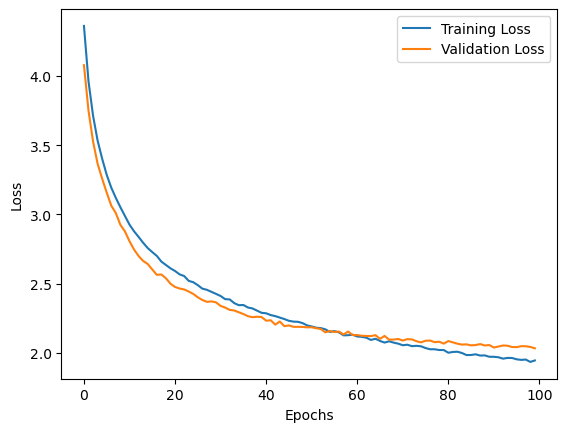

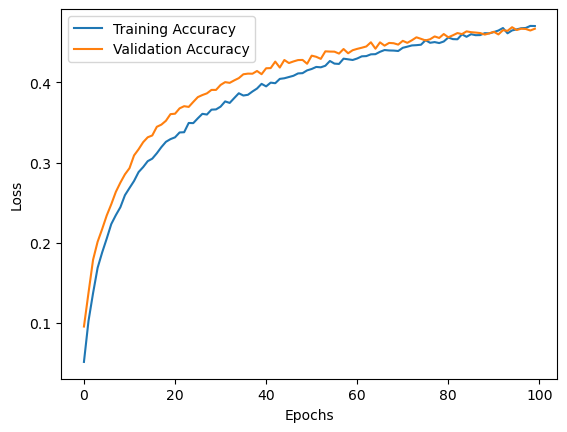

In [137]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [138]:
test_model(model, test_loader)

Test Accuracy: 46.3300%


In [ ]:
# Convergence seem to be slightly improve
# occurs earlier 
# may be noted for future use

In [139]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.8, 0.95))

In [140]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 2.9731, Training Accuracy: 0.2605
Epoch 9/100, Validation Loss: 2.7956, Validation Accuracy: 0.3024
Epoch 19/100, Training Loss: 2.6124, Training Accuracy: 0.3263
Epoch 19/100, Validation Loss: 2.4653, Validation Accuracy: 0.3612
Epoch 29/100, Training Loss: 2.4362, Training Accuracy: 0.3635
Epoch 29/100, Validation Loss: 2.3411, Validation Accuracy: 0.3898
Epoch 39/100, Training Loss: 2.3219, Training Accuracy: 0.3912
Epoch 39/100, Validation Loss: 2.2395, Validation Accuracy: 0.4117
Epoch 49/100, Training Loss: 2.2253, Training Accuracy: 0.4103
Epoch 49/100, Validation Loss: 2.1813, Validation Accuracy: 0.4311
Epoch 59/100, Training Loss: 2.1459, Training Accuracy: 0.4247
Epoch 59/100, Validation Loss: 2.1346, Validation Accuracy: 0.4370
Epoch 69/100, Training Loss: 2.1006, Training Accuracy: 0.4369
Epoch 69/100, Validation Loss: 2.0893, Validation Accuracy: 0.4492
Epoch 79/100, Training Loss: 2.0483, Training Accuracy: 0.4450
Epoch 79/100, Validation Loss

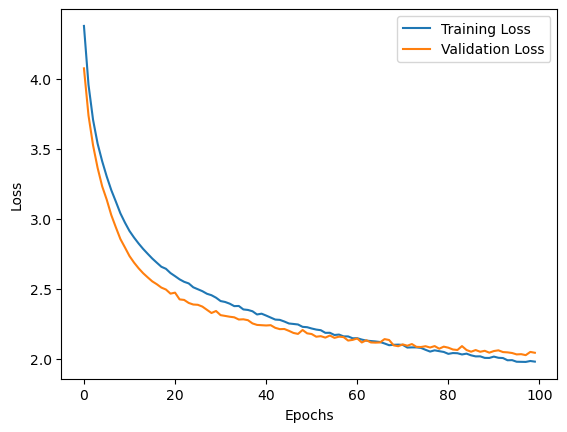

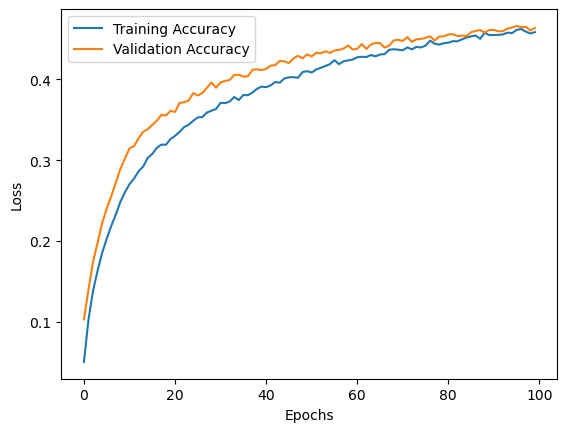

In [141]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [ ]:
# Slightly longer convergence by epoch
# not much of siginificant but will be noted
# nonetheless

In [142]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [143]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.0243, Training Accuracy: 0.2514
Epoch 9/100, Validation Loss: 2.8895, Validation Accuracy: 0.2779
Epoch 19/100, Training Loss: 2.6571, Training Accuracy: 0.3206
Epoch 19/100, Validation Loss: 2.5169, Validation Accuracy: 0.3536
Epoch 29/100, Training Loss: 2.4682, Training Accuracy: 0.3607
Epoch 29/100, Validation Loss: 2.3727, Validation Accuracy: 0.3885
Epoch 39/100, Training Loss: 2.3453, Training Accuracy: 0.3861
Epoch 39/100, Validation Loss: 2.2835, Validation Accuracy: 0.4091
Epoch 49/100, Training Loss: 2.2631, Training Accuracy: 0.4018
Epoch 49/100, Validation Loss: 2.2300, Validation Accuracy: 0.4232
Epoch 59/100, Training Loss: 2.1917, Training Accuracy: 0.4168
Epoch 59/100, Validation Loss: 2.1683, Validation Accuracy: 0.4343
Epoch 69/100, Training Loss: 2.1365, Training Accuracy: 0.4301
Epoch 69/100, Validation Loss: 2.1384, Validation Accuracy: 0.4413
Epoch 79/100, Training Loss: 2.0788, Training Accuracy: 0.4401
Epoch 79/100, Validation Loss

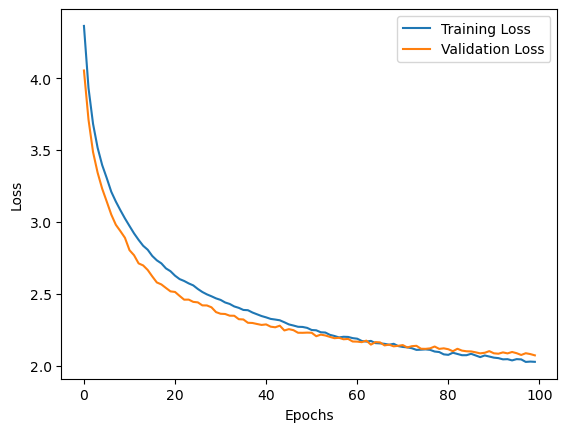

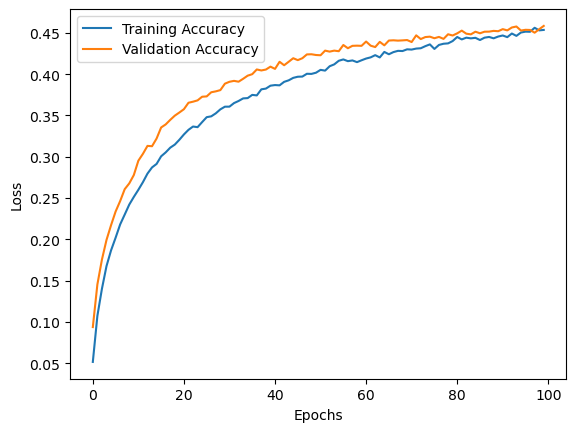

In [144]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [145]:
test_model(model, test_loader)

Test Accuracy: 45.5800%


In [ ]:
# Similar case once more
# Slightly longer convergence by epoch
# not much of siginificant but will be noted
# nonetheless
# Sticking with the 0.78, 0.90 betas config

## 2c.8 Trying out different combinations of Activation 

# Best model '1' LetNet modified

In [146]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + LeakyReLU + Average Pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), 
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 16x16x32

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 6x6x64

        # Fully connected layers LeakyReLU
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240, bias=True),  
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(240)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120, bias=True),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)  # CIFAR-100 has 100 classes
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [147]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [148]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.0175, Training Accuracy: 0.2544
Epoch 9/100, Validation Loss: 2.8581, Validation Accuracy: 0.2871
Epoch 19/100, Training Loss: 2.6499, Training Accuracy: 0.3220
Epoch 19/100, Validation Loss: 2.5347, Validation Accuracy: 0.3487
Epoch 29/100, Training Loss: 2.4554, Training Accuracy: 0.3641
Epoch 29/100, Validation Loss: 2.3693, Validation Accuracy: 0.3888
Epoch 39/100, Training Loss: 2.3220, Training Accuracy: 0.3915
Epoch 39/100, Validation Loss: 2.2819, Validation Accuracy: 0.4066
Epoch 49/100, Training Loss: 2.2343, Training Accuracy: 0.4091
Epoch 49/100, Validation Loss: 2.1882, Validation Accuracy: 0.4293
Epoch 59/100, Training Loss: 2.1649, Training Accuracy: 0.4224
Epoch 59/100, Validation Loss: 2.1662, Validation Accuracy: 0.4337
Epoch 69/100, Training Loss: 2.1152, Training Accuracy: 0.4331
Epoch 69/100, Validation Loss: 2.1218, Validation Accuracy: 0.4446
Epoch 79/100, Training Loss: 2.0570, Training Accuracy: 0.4452
Epoch 79/100, Validation Loss

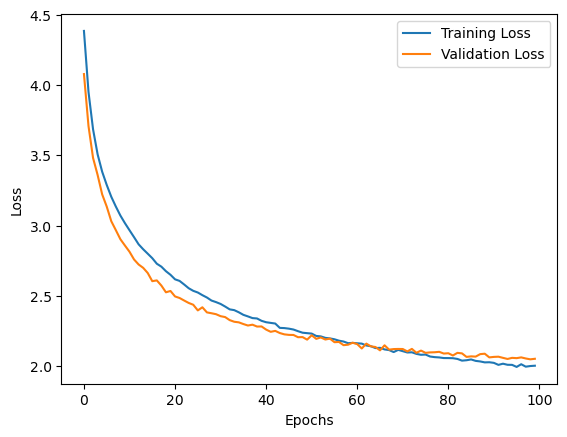

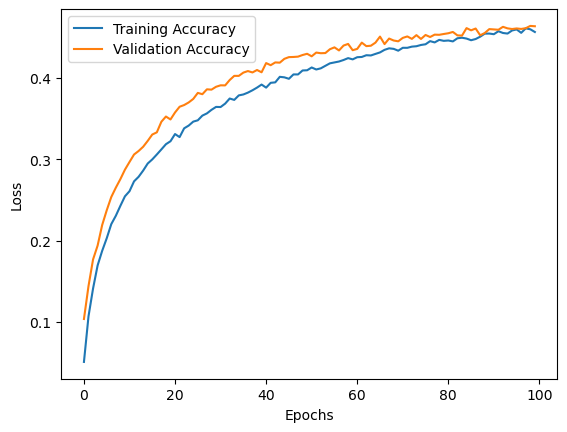

In [150]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [151]:
test_model(model, test_loader)

Test Accuracy: 46.4300%


In [ ]:
# Test Accuracy improve seem minor changes on the curves
# Uses this for the best model at this current one

In [162]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + ELU + Average Pooling
        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), # Increase from 16 to 32 channels
            nn.ELU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 16x16x16

        # Layer 1: Conv2d + ELU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # Increase from 32 to 64 channels
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 5x5x32 (without padding)

        # Fully connected layers leakyReLU
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240, bias=True), # increase 120 to 240 channels 
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(240)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120, bias=True),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)  # CIFAR-100 has 100 classes
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [163]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [164]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.2959, Training Accuracy: 0.2023
Epoch 9/100, Validation Loss: 3.1367, Validation Accuracy: 0.2334
Epoch 19/100, Training Loss: 2.9705, Training Accuracy: 0.2621
Epoch 19/100, Validation Loss: 2.8270, Validation Accuracy: 0.2943
Epoch 29/100, Training Loss: 2.7623, Training Accuracy: 0.3041
Epoch 29/100, Validation Loss: 2.6517, Validation Accuracy: 0.3322
Epoch 39/100, Training Loss: 2.6212, Training Accuracy: 0.3299
Epoch 39/100, Validation Loss: 2.5385, Validation Accuracy: 0.3524
Epoch 49/100, Training Loss: 2.5281, Training Accuracy: 0.3480
Epoch 49/100, Validation Loss: 2.4587, Validation Accuracy: 0.3708
Epoch 59/100, Training Loss: 2.4506, Training Accuracy: 0.3624
Epoch 59/100, Validation Loss: 2.4138, Validation Accuracy: 0.3827
Epoch 69/100, Training Loss: 2.3950, Training Accuracy: 0.3769
Epoch 69/100, Validation Loss: 2.3854, Validation Accuracy: 0.3871
Epoch 79/100, Training Loss: 2.3399, Training Accuracy: 0.3878
Epoch 79/100, Validation Loss

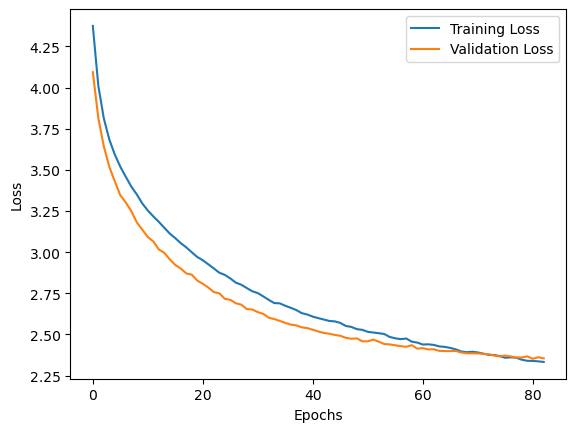

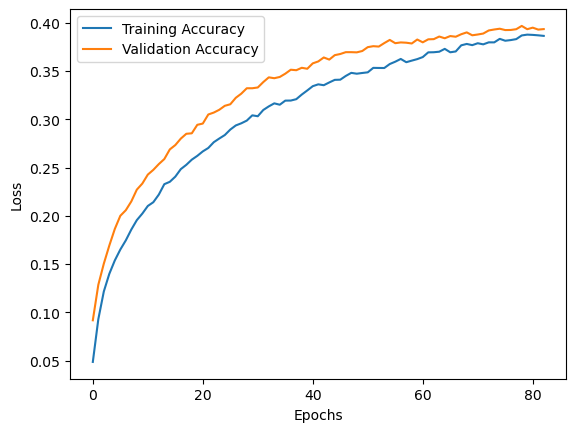

In [165]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [166]:
test_model(model, test_loader)

Test Accuracy: 39.6300%


In [ ]:
# Convergence increase 

In [167]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # layer1 include conv and max pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), # Increase from 16 to 32 channels
            nn.Sigmoid(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 16x16x16

        # Layer 2: Convolutional + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # Increase from 32 to 64 channels
            nn.Sigmoid(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 5x5x32 (without padding)

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240, bias=True), # increase 120 to 240 channels 
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(240)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120, bias=True),
            nn.Sigmoid()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)  # CIFAR-100 has 100 classes
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [169]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [170]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, num_epochs)

Epoch 9/100, Training Loss: 3.6864, Training Accuracy: 0.1393
Epoch 9/100, Validation Loss: 3.5870, Validation Accuracy: 0.1550
Epoch 19/100, Training Loss: 3.4243, Training Accuracy: 0.1817
Epoch 19/100, Validation Loss: 3.3149, Validation Accuracy: 0.2039
Epoch 29/100, Training Loss: 3.2210, Training Accuracy: 0.2145
Epoch 29/100, Validation Loss: 3.1123, Validation Accuracy: 0.2335
Epoch 39/100, Training Loss: 3.0504, Training Accuracy: 0.2439
Epoch 39/100, Validation Loss: 2.9439, Validation Accuracy: 0.2644
Epoch 49/100, Training Loss: 2.9209, Training Accuracy: 0.2692
Epoch 49/100, Validation Loss: 2.8359, Validation Accuracy: 0.2902
Epoch 59/100, Training Loss: 2.8098, Training Accuracy: 0.2901
Epoch 59/100, Validation Loss: 2.7353, Validation Accuracy: 0.3089
Epoch 69/100, Training Loss: 2.7421, Training Accuracy: 0.3055
Epoch 69/100, Validation Loss: 2.6592, Validation Accuracy: 0.3236
Epoch 79/100, Training Loss: 2.6643, Training Accuracy: 0.3182
Epoch 79/100, Validation Loss

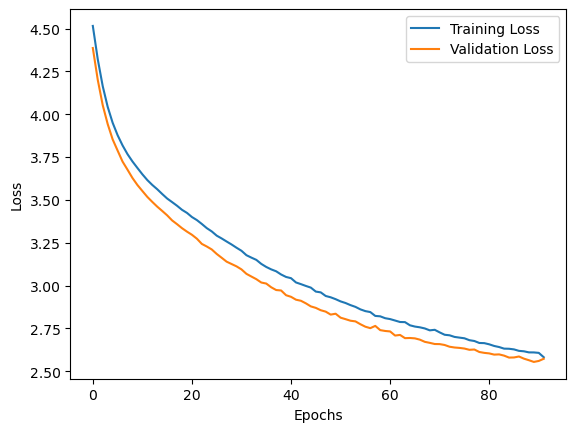

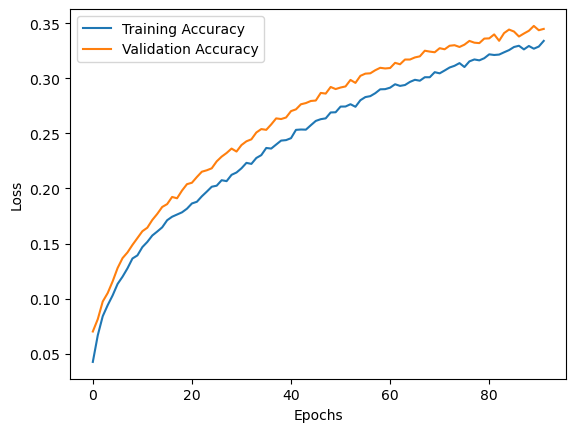

In [171]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [172]:
test_model(model, test_loader)

Test Accuracy: 34.9400%


In [ ]:
# Slight downgrade the convergence occurs later and the validation remains ahead of traning may suggest overfitting

## 2c.9 batch size

In [174]:
# First mode
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Input size for image CIFAR100 32x32 3 color channel  
        # Layer 1: Conv2d + LeakyReLU + Average Pooling

        # Input: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), 
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 16x16x32

        # Layer 2: Conv2d + ReLU + Average Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        # Output size: 6x6x64

        # Fully connected layers LeakyReLU
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=240, bias=True),  
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(240)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=240, out_features=120, bias=True),
            nn.ReLU()
        )
        # Output layer
        self.fc3 = nn.Linear(in_features=120, out_features=100)  # CIFAR-100 has 100 classes
        # output size is 100 to match classifciation of the labels of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for the fully connected layer
        out = self.fc1(out)
        out = self.fc2(out) 
        out = self.fc3(out) # criterion handle the softmax by the CrossEntropyLoss clasisfcation 
        return out


In [183]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [184]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, 128, num_epochs)

Epoch 9/100, Training Loss: 3.0992, Training Accuracy: 0.2412
Epoch 9/100, Validation Loss: 2.9561, Validation Accuracy: 0.2643
Epoch 19/100, Training Loss: 2.6945, Training Accuracy: 0.3121
Epoch 19/100, Validation Loss: 2.5838, Validation Accuracy: 0.3343
Epoch 29/100, Training Loss: 2.4945, Training Accuracy: 0.3515
Epoch 29/100, Validation Loss: 2.4139, Validation Accuracy: 0.3741
Epoch 39/100, Training Loss: 2.3515, Training Accuracy: 0.3841
Epoch 39/100, Validation Loss: 2.3229, Validation Accuracy: 0.3964
Epoch 49/100, Training Loss: 2.2486, Training Accuracy: 0.4012
Epoch 49/100, Validation Loss: 2.2504, Validation Accuracy: 0.4145
Early stopping on epoch 55/100
Training Completed


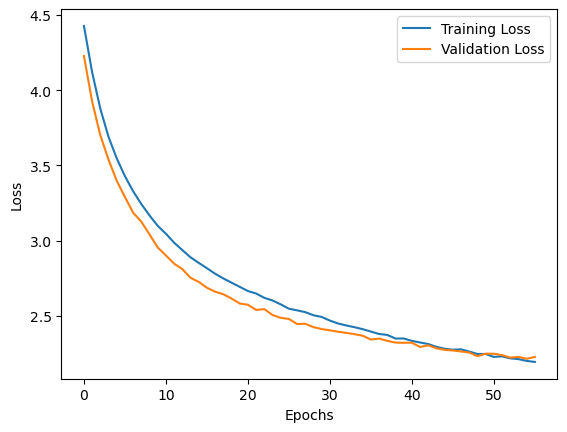

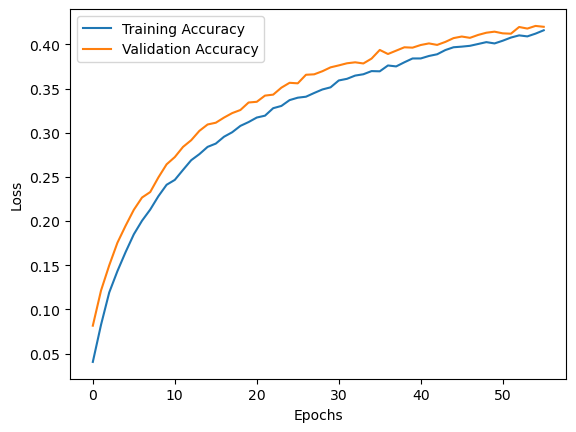

In [185]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [186]:
test_model(model, test_loader)

Test Accuracy: 41.9900%


In [ ]:
# BATCH SIZE 32

In [189]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [190]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, 32, num_epochs)

Epoch 9/100, Training Loss: 2.9319, Training Accuracy: 0.2670
Epoch 9/100, Validation Loss: 2.7070, Validation Accuracy: 0.3105
Epoch 19/100, Training Loss: 2.6253, Training Accuracy: 0.3265
Epoch 19/100, Validation Loss: 2.4051, Validation Accuracy: 0.3814
Epoch 29/100, Training Loss: 2.4757, Training Accuracy: 0.3604
Epoch 29/100, Validation Loss: 2.2865, Validation Accuracy: 0.4033
Epoch 39/100, Training Loss: 2.3801, Training Accuracy: 0.3801
Epoch 39/100, Validation Loss: 2.2480, Validation Accuracy: 0.4176
Early stopping on epoch 48/100
Training Completed


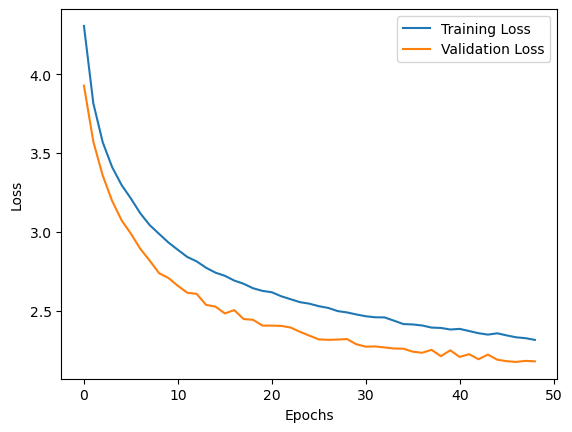

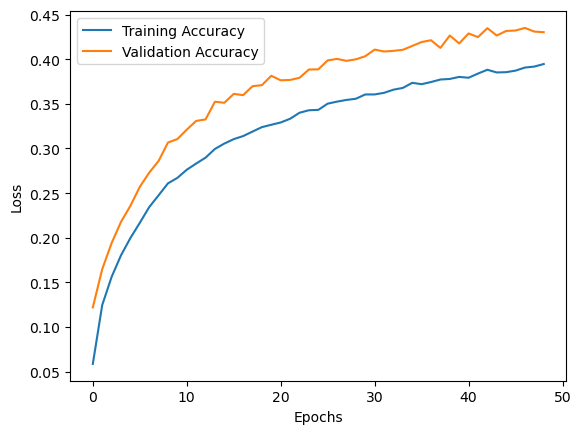

In [192]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)

In [193]:
test_model(model, test_loader)

Test Accuracy: 43.0900%


In [204]:

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
# Examine the effects in Adam  default lr 
optimizer= optim.Adam(model.parameters(),lr=1e-4, betas=(0.78, 0.90))

In [205]:
tr_acc, tr_loss, val_acc, val_loss = train_model(model, optimizer, criterion, subtrain_dataset, validation_dataset, batch_size, 32)

Epoch 9/32, Training Loss: 2.9555, Training Accuracy: 0.2621
Epoch 9/32, Validation Loss: 2.8036, Validation Accuracy: 0.2949
Epoch 19/32, Training Loss: 2.6000, Training Accuracy: 0.3341
Epoch 19/32, Validation Loss: 2.4768, Validation Accuracy: 0.3654
Epoch 29/32, Training Loss: 2.4145, Training Accuracy: 0.3693
Epoch 29/32, Validation Loss: 2.3187, Validation Accuracy: 0.3992
Training Completed


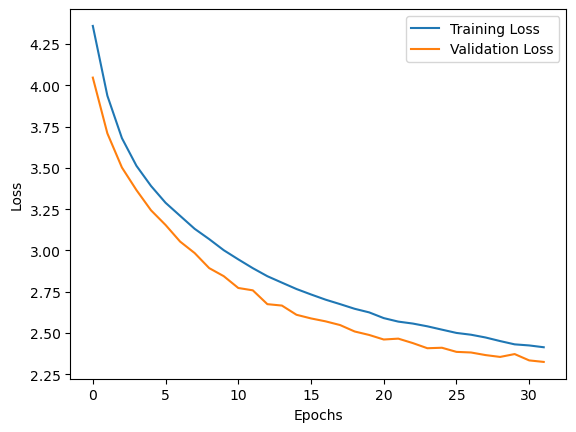

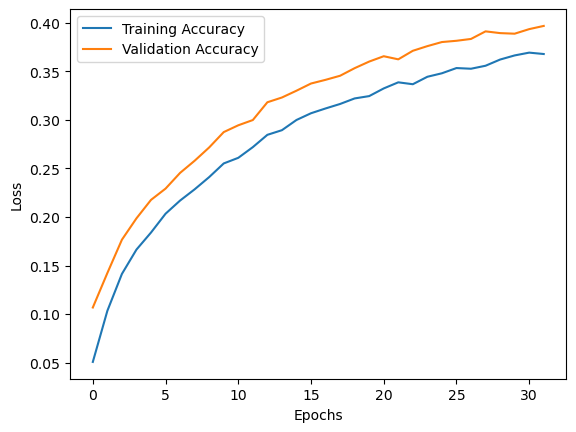

In [199]:
plot_model(tr_acc, tr_loss, val_acc, val_loss)